In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

pd.options.display.max_rows = 500

# combine hazard maps

In [2]:
maps = []

# for i in tqdm(range(1, 48)):  # all
for i in tqdm(range(13, 14)):  # only tokyo    
    dir_path = Path('../data/input/hazard_maps/A31-12_{:0>2}_GML'.format(i))
    paths = list(dir_path.glob('**/A31-12_{:0>2}.shp'.format(i)))
    assert len(paths) == 1
    map_gdf = gpd.read_file(paths[0], encoding='shift-jis')
    maps.append(map_gdf)

crs = maps[0].crs

In [3]:
maps_gdf = gpd.GeoDataFrame(pd.concat(maps, axis=0))
maps_gdf.crs = crs

In [4]:
depth_map = {
    11:11, 12:12, 13:13, 14:14, 15:15,
    21:11, 22:12, 23:13, 24:14, 25:14, 26:14, 27:15 
}

new_cols = [
    'water_depth',
    'area_code',
    'author',
    'map_date',
    'map_doc',
    'detail_file_id',
    'geometry'
]

In [5]:
maps_gdf.columns = new_cols
maps_gdf['water_depth_scaled'] = maps_gdf['water_depth'].map(depth_map)
print(maps_gdf.shape)
maps_gdf.head()

(7303, 8)


,water_depth,area_code,author,map_date,map_doc,detail_file_id,geometry,water_depth_scaled
0,11,11,埼玉県 県土整備部 河川砂防課,平成19年3月27日,埼玉県告示第504号,11005,"POLYGON ((139.76750 35.81768, 139.76764 35.817...",11
1,11,11,埼玉県 県土整備部 河川砂防課,平成19年3月27日,埼玉県告示第504号,11005,"POLYGON ((139.82038 35.80685, 139.82018 35.806...",11
2,11,11,埼玉県 県土整備部 河川砂防課,平成19年3月27日,埼玉県告示第504号,11005,"POLYGON ((139.81949 35.80380, 139.81922 35.803...",11
3,11,11,埼玉県 県土整備部 河川砂防課,平成19年3月27日,埼玉県告示第504号,11005,"POLYGON ((139.82695 35.79197, 139.82682 35.791...",11
4,11,11,埼玉県 県土整備部 河川砂防課,平成19年3月27日,埼玉県告示第504号,11005,"POLYGON ((139.82472 35.79228, 139.82444 35.792...",11


In [6]:
%%time
# maps_gdf.to_file('../data/input/hazard_maps/hazard_maps.geojson', driver='GeoJSON')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


# convert timeseries

In [7]:
%%time
# maps_gdf = gpd.read_file('../data/input/hazard_maps/hazard_maps.geojson')

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 3.81 µs


In [8]:
maps_gdf['map_date'].unique()

array(['平成19年3月27日', '平成22年9月2日', '記載なし', '平成17年3月28日', '平成17年7月8日',
       '平成17年7月7日', '平成14年2月28日', '平成18年2月15日', '平成18年7月6日'], dtype=object)

In [9]:
maps_gdf['year_japan'] = maps_gdf['map_date'].str.extract('((?<=平成).*?(?=年))', expand=False)
maps_gdf['month'] = maps_gdf['map_date'].str.extract('((?<=年).*?(?=月))', expand=False)
maps_gdf['day'] = maps_gdf['map_date'].str.extract('((?<=月).*?(?=日))', expand=False)

In [10]:
date_cols = ['year_japan', 'month', 'day']

for col in date_cols:
    print(col, maps_gdf[col].unique())

year_japan ['19' '22' nan '17' '14' '18']
month ['3' '9' nan '7' '2']
day ['27' '2' nan '28' '8' '7' '15' '6']


In [11]:
maps_gdf['month'] = maps_gdf['month'].str.replace('\（[^()]*\）', '')

In [12]:
for col in date_cols:
    maps_gdf[col] = maps_gdf[col].str.replace('\u3000', '')
    maps_gdf[col] = maps_gdf[col].replace('', np.nan)
    maps_gdf[col] = maps_gdf[col].astype(float)

In [13]:
maps_gdf['year'] = maps_gdf['year_japan'] + 1988

In [14]:
date_cols = ['year', 'month', 'day']

for col in date_cols:
    print(col, maps_gdf[col].unique())

year [2007. 2010.   nan 2005. 2002. 2006.]
month [ 3.  9. nan  7.  2.]
day [27.  2. nan 28.  8.  7. 15.  6.]


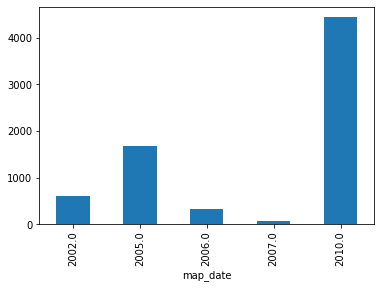

In [15]:
maps_gdf['map_date'] = pd.to_datetime(maps_gdf[date_cols])
maps_gdf.groupby(maps_gdf['map_date'].dt.year).count()['year'].plot(kind='bar')

In [16]:
maps_gdf.drop(date_cols + ['year_japan'], axis=1, inplace=True)

In [17]:
print(maps_gdf.shape)
maps_gdf.head(100)

(7303, 8)


,water_depth,area_code,author,map_date,map_doc,detail_file_id,geometry,water_depth_scaled
0,11,11,埼玉県 県土整備部 河川砂防課,2007-03-27,埼玉県告示第504号,11005,"POLYGON ((139.76750 35.81768, 139.76764 35.817...",11
1,11,11,埼玉県 県土整備部 河川砂防課,2007-03-27,埼玉県告示第504号,11005,"POLYGON ((139.82038 35.80685, 139.82018 35.806...",11
2,11,11,埼玉県 県土整備部 河川砂防課,2007-03-27,埼玉県告示第504号,11005,"POLYGON ((139.81949 35.80380, 139.81922 35.803...",11
3,11,11,埼玉県 県土整備部 河川砂防課,2007-03-27,埼玉県告示第504号,11005,"POLYGON ((139.82695 35.79197, 139.82682 35.791...",11
4,11,11,埼玉県 県土整備部 河川砂防課,2007-03-27,埼玉県告示第504号,11005,"POLYGON ((139.82472 35.79228, 139.82444 35.792...",11
5,11,11,埼玉県 県土整備部 河川砂防課,2007-03-27,埼玉県告示第504号,11005,"POLYGON ((139.79462 35.80529, 139.79462 35.805...",11
6,11,11,埼玉県 県土整備部 河川砂防課,2007-03-27,埼玉県告示第504号,11005,"POLYGON ((139.80742 35.80171, 139.80736 35.802...",11
7,11,11,埼玉県 県土整備部 河川砂防課,2007-03-27,埼玉県告示第504号,11005,"POLYGON ((139.80779 35.78712, 139.80610 35.787...",11
8,11,11,埼玉県 県土整備部 河川砂防課,2007-03-27,埼玉県告示第504号,11005,"POLYGON ((139.75006 35.77782, 139.75000 35.777...",11
9,13,11,埼玉県 県土整備部 河川砂防課,2007-03-27,埼玉県告示第504号,11005,"POLYGON ((139.77297 35.81159, 139.77284 35.811...",13


In [18]:
%%time
# maps_gdf.to_file('../data/input/hazard_maps/hazard_maps.geojson', driver='GeoJSON') # all
maps_gdf.to_file('../data/input/hazard_maps/hazard_maps_tokyo.geojson', driver='GeoJSON') # only tokyo

CPU times: user 2.6 s, sys: 36.6 ms, total: 2.64 s
Wall time: 2.65 s


In [19]:
maps_gdf.dtypes

water_depth                    int64
area_code                      int64
author                        object
map_date              datetime64[ns]
map_doc                       object
detail_file_id                object
geometry                    geometry
water_depth_scaled             int64
dtype: object